In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService
import os
n_jobs = 16
os.environ["OMP_NUM_THREADS"] = str(n_jobs)
import joblib
import click
import json
import time
from glob import glob
import itertools
import collections.abc
import sys
from tqdm.notebook import tqdm
# !{sys.executable} -m pip install qcircuit
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pennylane as qml
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import re
from joblib import Parallel, delayed, dump, load


In [2]:
top=os.getcwd()
with open(os.path.join(top,'5_DDCC_train.bin'),'rb') as f:
    ddcc_train = joblib.load(f)

with open(os.path.join(top,'5_DDCC_test.bin'),'rb') as f:
    ddcc_test = joblib.load(f)

with open(os.path.join(top,'5_DDCC_scaler.bin'),'rb') as f:
    ddcc_scaler = joblib.load(f)

X_ddcc_train, y_ddcc_train = ddcc_train['X'],ddcc_train['y']
X_ddcc_test, y_ddcc_test = ddcc_test['X'],ddcc_test['y']

X_ddcc_train = X_ddcc_train.reshape(-1,64,5)[0:4]
X_ddcc_test = X_ddcc_test.reshape(-1,64,5)[0:4]
y_ddcc_train = y_ddcc_train.reshape(-1,64)[0:4]
y_ddcc_test = y_ddcc_test.reshape(-1,64)[0:4]


# X_train, y_train = X_ddcc_train, y_ddcc_train
# X_test, y_test = X_ddcc_test, y_ddcc_test
X_train, y_train = X_ddcc_train, y_ddcc_train
X_test, y_test = X_ddcc_test, y_ddcc_test

# X_train = [X_train[i:i+4] for i in range(0,len(X_train),4)]
# X_test = [X_test[i:i+4] for i in range(0,len(X_test),4)]
scaler = ddcc_scaler

# print(len(X_train),X_train[0].shape,X_train[-1].shape)
print(y_train.shape, y_test.shape)

(4, 64) (4, 64)


/Users/grierjones/miniconda3/envs/simple_qml/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
def grab_data(path):
    '''
    Given a globbed path, return the job_n.txt, *_train.txt, and *_test.txt files
    '''
    iterations = []
    train_metric = []
    test_metric = []
    for i in path:
        try:
            numbers = int(re.search(r'jobs_(\d+)\.txt', i).group(1))
            iterations.append(i)
        except:
            if 'test' in i:
                test_metric.append(i)
            else:
                train_metric.append(i)
            
    return sorted(iterations,key=lambda x: int(re.search(r'jobs_(\d+)\.txt', x).group(1))), train_metric, test_metric

In [4]:
def fetch_jobs_from_file(service, filename):
    """Fetch all job results from a given file."""
    with open(filename, 'r') as f:
        job_ids = f.readlines()
    return [service.job(job_id.strip()).result() for job_id in job_ids]

def grab_jobs(lst):
    """Parallelize over job files, fetching results concurrently."""
    service = QiskitRuntimeService(
        channel='ibm_quantum',
        instance='pinq-quebec-hub/univ-toronto/default'
    )

    # Parallel processing of files
    jobs = Parallel(n_jobs=-1,backend='threading')(
        delayed(fetch_jobs_from_file)(service, filename) for filename in tqdm(lst)
    )

    return np.array(jobs)

In [5]:
iter_x, train_x, test_x = grab_data(glob('./*txt'))


In [6]:
# results_x = grab_jobs(iter_x[0:-1])
# y_x = np.array([[[k.data.evs.flatten() for k in j] for j in i] for i in results_x]).reshape(*results_x.shape)


# with open('y_x.npy', 'wb') as f:
#     np.save(f, y_x)


with open('y_x.npy', 'rb') as f:
    y_x = np.load(f)


In [7]:

y_x = scaler.inverse_transform(y_x.flatten().reshape(-1,1)).reshape(*y_x.shape)



y_ddcc_train = scaler.inverse_transform(y_ddcc_train.flatten().reshape(-1,1)).reshape(*y_ddcc_train.shape)
y_ddcc_test = scaler.inverse_transform(y_ddcc_test.flatten().reshape(-1,1)).reshape(*y_ddcc_test.shape)

In [8]:
MSE_x = [mean_squared_error(y_ddcc_train.flatten(),i.flatten()) for i in y_x]

combined_MSE = MSE_x
min_MSE_idx = np.argmin(MSE_x)

In [9]:
best_train = np.vstack([y_x])[min_MSE_idx]

In [10]:
with open(os.path.join(os.path.expanduser('~'),'qregress/qml_DDCC/RUD_AL/5AL/A2_HWE-CNOT/A2_HWE-CNOT.json')) as f:
    statevector = json.load(f)

In [18]:
statevectordf = pd.read_csv(os.path.join(os.path.expanduser('~'),'qregress/qml_DDCC/RUD_AL/5AL/A2_HWE-CNOT/A2_HWE-CNOT_predicted_values.csv'))
statevectordf['Predicted'] = [float(i.strip('[]')) for i in statevectordf['Predicted']]
statevectordf['Reference'] = [float(i.strip('[]')) for i in statevectordf['Reference']]
statevectordf['Device'] = len(statevectordf)*['State Vector']



In [19]:
statevectordf

,Data,Predicted,Reference,Device
0,Train,-0.026145,-3.225819e-02,State Vector
1,Train,0.006276,-7.769852e-07,State Vector
2,Train,0.006276,-7.769852e-07,State Vector
3,Train,-0.019815,-1.690866e-02,State Vector
4,Train,0.004060,2.147516e-06,State Vector
...,...,...,...,...
12731,Test,0.001562,-1.675672e-16,State Vector
12732,Test,-0.018692,-2.660935e-02,State Vector
12733,Test,0.003227,1.556219e-05,State Vector
12734,Test,0.003227,1.556219e-05,State Vector


In [20]:
dfbest = pd.DataFrame(np.vstack([y_ddcc_train.flatten(),best_train.flatten()]),index=['Reference','Predicted']).T
dfbest['Device'] = len(dfbest)*['ibm_quebec']
dfbest['Data'] = len(dfbest)*['Train']

<Axes: xlabel='Reference', ylabel='Predicted'>

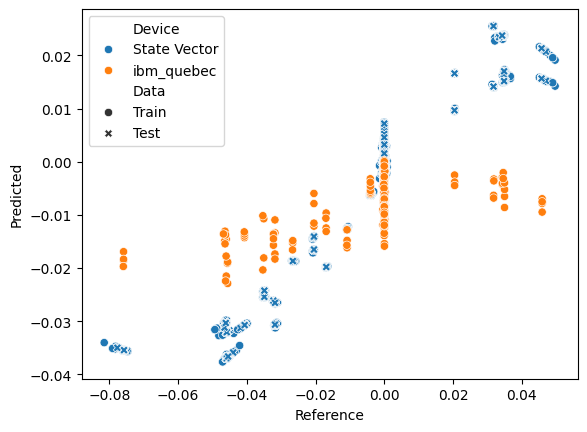

In [21]:
sns.scatterplot(data=pd.concat([statevectordf,dfbest]),x='Reference',y='Predicted',hue='Device',style='Data')

In [22]:
statevectordf.max()

Data                Train
Predicted        0.025557
Reference        0.049732
Device       State Vector
dtype: object

/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_19624/2307513888.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


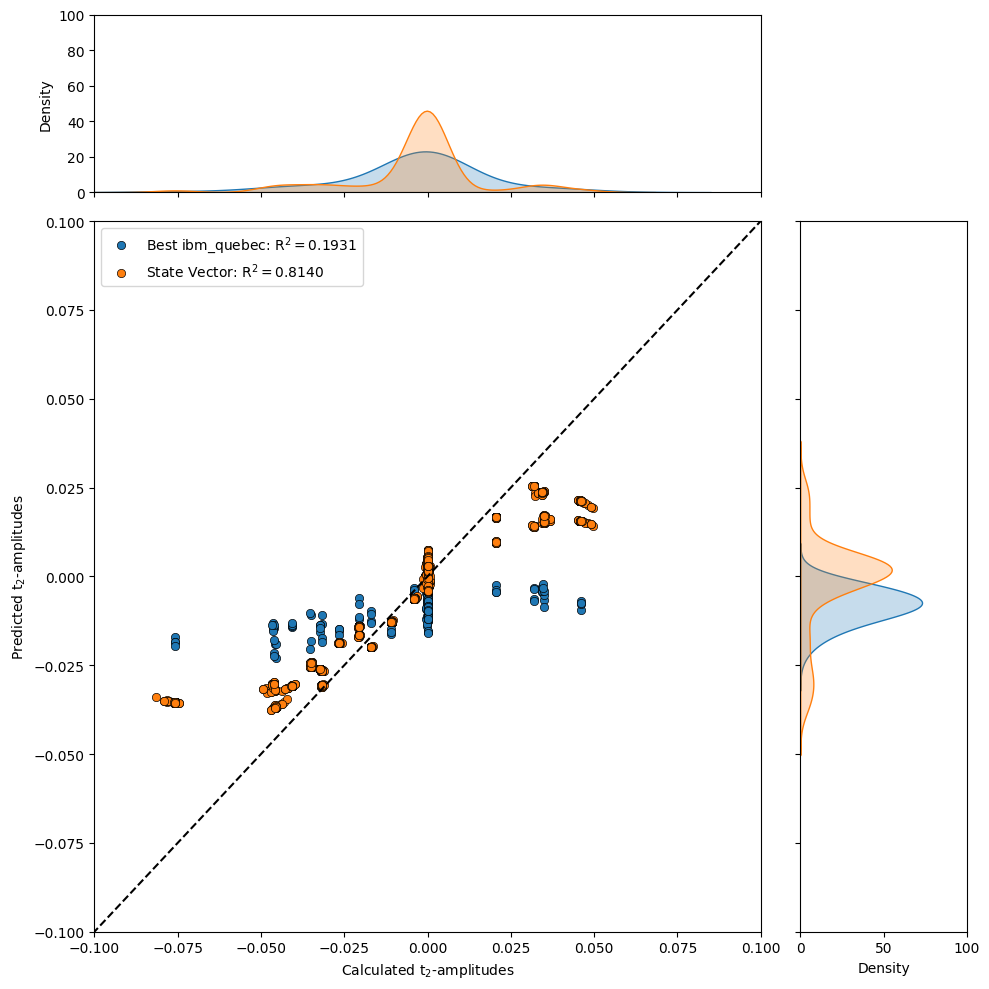

In [23]:
spread = 10e-2
# Create the figure with a 2D grid (scatter + KDE for Predicted + KDE for Reference)
fig, axes = plt.subplots(
    2, 2, 
    figsize=(10, 10),
    gridspec_kw={'width_ratios': [4, 1], 'height_ratios': [1, 4]},
    constrained_layout=True,
    # sharey='row',  # Keep y-axis sharing, but remove sharex to control ticks manually,
    # sharex='col'
)
axes[0, -1].axis("off")
sns.scatterplot(data=dfbest,x='Reference',y='Predicted',label="Best ibm_quebec: R$^{2}=$"+f"{r2_score(dfbest['Reference'],dfbest['Predicted']):.4f}", edgecolors='black',ax=axes[1,0])
sns.scatterplot(data=statevectordf[statevectordf['Data']=='Train'],x='Reference',y='Predicted',label="State Vector: R$^{2}=$"+f"{r2_score(statevectordf['Reference'],statevectordf['Predicted']):.4f}", edgecolors='black',ax=axes[1,0])
axes[1,0].plot(range(-1,2),range(-1,2),'k--')
axes[1,0].set_ylim(-spread,spread)
axes[1,0].set_xlim(-spread,spread)
axes[1,0].set_ylabel("Predicted t$_{2}$-amplitudes")
axes[1,0].set_xlabel("Calculated t$_{2}$-amplitudes")
axes[1,0].legend()


# sns.kdeplot(data=pd.concat([dfbest,statevectordf[statevectordf['Data']=='Train']]),hue='Device',x='Reference',ax=axes[0,0],fill=True)
sns.kdeplot(data=dfbest,x='Reference',ax=axes[0,0],fill=True, bw_adjust=2)
sns.kdeplot(data=statevectordf[statevectordf['Data']=='Train'],x='Reference',ax=axes[0,0],fill=True, bw_adjust=2)
axes[0,0].set_xticklabels([])  # Hide labels but keep ticks
axes[0,0].set_xlabel("")  # Remove x-labels
axes[0,0].set_xlim(-spread,spread)
axes[0,0].set_ylim(0,100)

# sns.kdeplot(data=pd.concat([dfbest,statevectordf[statevectordf['Data']=='Train']]),hue='Device',y='Predicted',ax=axes[1,1],fill=True)
sns.kdeplot(data=dfbest,y='Predicted',ax=axes[1,1],fill=True, bw_adjust=2)
sns.kdeplot(data=statevectordf[statevectordf['Data']=='Train'],y='Predicted',ax=axes[1,1],fill=True, bw_adjust=2)
axes[1,1].set_yticklabels([])  # Hide labels but keep ticks
axes[1,1].set_ylabel("")  # Remove x-labels
axes[1,1].set_ylim(-spread,spread)
axes[1,1].set_xlim(0,100)
# plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Adjust width and height spacing
plt.tight_layout()
# plt.savefig(os.path.join(os.path.expanduser('~'),'qregress/images/DDCC/bestibm_vs_statevector.png'),dpi=300,bbox_inches='tight')
plt.show()

In [17]:
finaldf = pd.DataFrame(np.hstack([np.vstack([y_ddcc_train.flatten(),y_x0_train.flatten()]),np.vstack([y_ddcc_test.flatten(),y_x0_test.flatten()])]),index=['Predicted','Reference']).T
finaldf['Data'] = len(y_ddcc_train.flatten())*['Train']+len(y_ddcc_test.flatten())*['Test']
finaldf['Device'] = len(finaldf)*['ibm_quebec']

NameError: name 'y_x0_train' is not defined

In [ ]:
spread = 10e-2
# Create the figure with a 2D grid (scatter + KDE for Predicted + KDE for Reference)
fig, axes = plt.subplots(
    2, 2, 
    figsize=(10, 10),
    gridspec_kw={'width_ratios': [4, 1], 'height_ratios': [1, 4]},
    constrained_layout=True,
    # sharey='row',  # Keep y-axis sharing, but remove sharex to control ticks manually,
    # sharex='col'
)
axes[0, -1].axis("off")
sns.scatterplot(data=finaldf,x='Reference',y='Predicted',hue='Data',style='Device', edgecolors='black',ax=axes[1,0])
sns.scatterplot(data=statevectordf,hue='Data',x='Reference',y='Predicted',style='Device', edgecolors='black',ax=axes[1,0])
axes[1,0].plot(range(-1,2),range(-1,2),'k--')
axes[1,0].set_ylim(-spread,spread)
axes[1,0].set_xlim(-spread,spread)
axes[1,0].set_ylabel("Predicted t$_{2}$-amplitudes")
axes[1,0].set_xlabel("Calculated t$_{2}$-amplitudes")
axes[1,0].legend()


# sns.kdeplot(data=pd.concat([dfbest,statevectordf[statevectordf['Data']=='Train']]),hue='Device',x='Reference',ax=axes[0,0],fill=True)
sns.kdeplot(data=finaldf,hue='Data',x='Reference',ax=axes[0,0],fill=True, bw_adjust=2)
sns.kdeplot(data=statevectordf,hue='Data',x='Reference',ax=axes[0,0],fill=True, bw_adjust=2)
axes[0,0].set_xticklabels([])  # Hide labels but keep ticks
axes[0,0].set_xlabel("")  # Remove x-labels
axes[0,0].set_xlim(-spread,spread)
axes[0,0].set_ylim(0,100)

# sns.kdeplot(data=pd.concat([dfbest,statevectordf[statevectordf['Data']=='Train']]),hue='Device',y='Predicted',ax=axes[1,1],fill=True)
sns.kdeplot(data=finaldf,hue='Data',y='Predicted',ax=axes[1,1],fill=True, bw_adjust=2)
sns.kdeplot(data=statevectordf,hue='Data',y='Predicted',ax=axes[1,1],fill=True, bw_adjust=2)
axes[1,1].set_yticklabels([])  # Hide labels but keep ticks
axes[1,1].set_ylabel("")  # Remove x-labels
axes[1,1].set_ylim(-spread,spread)
axes[1,1].set_xlim(0,100)
# plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Adjust width and height spacing
plt.tight_layout()
plt.show()

In [ ]:
len([len(y_ddcc_train.flatten())*['Train']]+[len(y_ddcc_test.flatten())*['Test']])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score

fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plots
ax.scatter(y_ddcc_train.flatten(), y_x0_train.flatten(), 
           label="ibm_quebec Train R$^{2}=$"+f"{r2_score(y_ddcc_train.flatten(), y_x0_train.flatten()):.4f}", 
           color='b', edgecolors='black')
ax.scatter(y_ddcc_test.flatten(), y_x0_test.flatten(), 
           label="ibm_quebec Test R$^{2}=$"+f"{r2_score(y_ddcc_test.flatten(), y_x0_test.flatten()):.4f}", 
           color='g', edgecolors='black')

sns.scatterplot(data=statevectordf[statevectordf['Data'] == 'Train'], x='Reference', y='Predicted', 
                label="State Vector Train: R$^{2}=$"+f"{r2_score(statevectordf[statevectordf['Data'] == 'Train']['Reference'], statevectordf[statevectordf['Data'] == 'Train']['Predicted']):.4f}", 
                ax=ax, edgecolor='black')

sns.scatterplot(data=statevectordf[statevectordf['Data'] == 'Test'], x='Reference', y='Predicted', 
                label="State Vector Test: R$^{2}=$"+f"{r2_score(statevectordf[statevectordf['Data'] == 'Test']['Reference'], statevectordf[statevectordf['Data'] == 'Test']['Predicted']):.4f}", 
                ax=ax, edgecolor='black')

# Identity line
ax.plot(np.linspace(-1, 2, 100), np.linspace(-1, 2, 100), 'k--')

ax.set_ylim(-3e-2, 3e-2)
ax.set_xlim(-3e-2, 3e-2)
ax.set_ylabel("Predicted t$_{2}$-amplitudes")
ax.set_xlabel("Calculated t$_{2}$-amplitudes")
ax.legend()
plt.tight_layout()

# Create twin axes for KDE plots
top_ax = ax.twiny()
right_ax = ax.twinx()

# KDE distributions
sns.kdeplot(statevectordf['Reference'], ax=top_ax, color='gray', lw=2, clip=(-3e-2, 3e-2))
sns.kdeplot(statevectordf['Predicted'], ax=right_ax, color='gray', lw=2, clip=(-3e-2, 3e-2))

# Hide tick labels for KDE axes
top_ax.set_xticks([])
right_ax.set_yticks([])

plt.show()


In [ ]:
plt.scatter(min_MSE_idx,combined_MSE[min_MSE_idx],color='r',label=f'MSE:{combined_MSE[min_MSE_idx]:.4e}')
plt.plot(MSE_x+MSE_500+MSE_x0)
plt.ylabel('Training Loss (MSE)')
plt.xlabel('Iterations')
plt.xlim(-10,900)
plt.ylim(0,8e-4)
plt.hlines(statevector['MSE_train'][0],-100,1e4,color='r',linestyle='--',label=f'State Vector MSE:{statevector['MSE_train'][0]:.4e}')
# plt.yscale('log')
plt.legend()
plt.tight_layout()
# plt.savefig(os.path.join(os.path.expanduser('~'),'qregress/images/DDCC/ibmq_loss.png'),dpi=300,bbox_inches='tight')
plt.show()